In [1]:
import sys 
sys.path.append('..')

import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian, value_and_grad
from jax.lax import scan
# from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np

from jax.flatten_util import ravel_pytree

import numpy as onp
from time_opt_erg_lib.dynamics import DoubleIntegrator, SingleIntegrator

from time_opt_erg_lib.ergodic_metric import ErgodicMetric
from time_opt_erg_lib.obstacle import Obstacle
from time_opt_erg_lib.cbf import constr2CBF
from time_opt_erg_lib.fourier_utils import BasisFunc, get_phik, get_ck
from time_opt_erg_lib.target_distribution import TargetDistribution
from time_opt_erg_lib.cbf_utils import sdf2cbf
from IPython.display import clear_output
import matplotlib.pyplot as plt

from time_opt_erg_lib.opt_solver import AugmentedLagrangeSolver
import yaml
import pickle as pkl


In [16]:
basis           = BasisFunc(n_basis=[10,10])
erg_metric      = ErgodicMetric(basis)
robot_model     = SingleIntegrator()
n,m = robot_model.n, robot_model.m
target_distr    = TargetDistribution()
workspace_bnds = [[0.,1.0],[0.,1.0]]

with open('../config/obs.yml', 'r') as file:
    obs_info = yaml.safe_load(file)

obs = []
cbf_constr = []
for obs_name in obs_info:
    _ob = Obstacle(obs_info[obs_name])
        # pos=np.array(obs_info[obs_name]['pos']), 
        # half_dims=np.array(obs_info[obs_name]['half_dims']),
        # th=obs_info[obs_name]['rot']
    obs.append(_ob)
    cbf_constr.append(sdf2cbf(robot_model.dfdt, _ob.distance))


opt_args = {
    'N' : 100, 
    'x0' : np.array([.1,0.1]),
    'xf' : np.array([.9, 0.9]),
    'phik' : get_phik(target_distr.evals, basis),
    'erg_ub' : 0.1,
    'alpha' : 0.8,
}

@vmap
def emap(x):
    """ Function that maps states to workspace """
    return np.array([
        (x[0]-workspace_bnds[0][0])/(workspace_bnds[0][1]-workspace_bnds[0][0]), 
        (x[1]-workspace_bnds[1][0])/(workspace_bnds[1][1]-workspace_bnds[1][0])])
        
def barrier_cost(e):
    """ Barrier function to avoid robot going out of workspace """
    return (np.maximum(0, e-1) + np.maximum(0, -e))**2

# @jit
def loss(params, args):
    x = params['x']
    u = params['u']
    tf = params['tf']
    N = args['N']
    dt = tf/N
    e = emap(x)
    """ Traj opt loss function, not the same as erg metric """
    return np.sum(barrier_cost(e)) + tf

def eq_constr(params, args):
    """ dynamic equality constriants """
    x = params['x']
    u = params['u']

    x0 = args['x0']
    xf = args['xf']
    tf = params['tf']
    N = args['N']
    dt = tf/N
    return np.vstack([
        x[0] - x0, 
        x[1:,:]-(x[:-1,:]+dt*vmap(robot_model.dfdt)(x[:-1,:], u[:-1,:])),
        x[-1] - xf
    ])

def ineq_constr(params, args):
    """ inequality constraints"""
    x = params['x']
    u = params['u']
    phik = args['phik']
    tf = params['tf']
    N = args['N']
    dt = tf/N
    e = emap(x)
    _cbf_ineq = [vmap(_cbf_ineq, in_axes=(0,0,None, None))(x, u, args['alpha'], dt).flatten() 
               for _cbf_ineq in cbf_constr]
    ck = get_ck(e, basis, tf, dt)
    _erg_ineq = [np.array([erg_metric(ck, phik) - args['erg_ub'], -tf])]
    _ctrl_box = [(np.abs(u) - 1.).flatten()]
    return np.concatenate(_erg_ineq + _ctrl_box + _cbf_ineq)
    # return np.array([erg_metric(ck, phik) - 0.001, -tf] + [(np.abs(u) - 2.).flatten()])
    # return np.array(0.)
    # p = x[:,:2] # extract just the position component of the trajectory
    # # obs_val = [vmap(_ob.distance)(p).flatten() for _ob in self.obs]
    # obs_val = [vmap(_cbf_ineq)(x, u).flatten() for _cbf_ineq in self.cbf_consts]
    # ctrl_box = [(np.abs(u) - 2.).flatten()]
    # _ineq_list = ctrl_box + obs_val
    # return np.array(0.)


In [17]:
x = np.linspace(opt_args['x0'], opt_args['xf'], opt_args['N'], endpoint=True)
u = np.zeros((opt_args['N'], robot_model.m))
init_sol = {'x': x, 'u' : u, 'tf': np.array(10.0)}

In [18]:
solver = AugmentedLagrangeSolver(
                    init_sol,
                    loss, 
                    eq_constr, 
                    ineq_constr, 
                    opt_args, 
                    step_size=0.001,
                    c=1.0)

In [19]:
solver.solve(max_iter=10000)

done in  1189  iterations


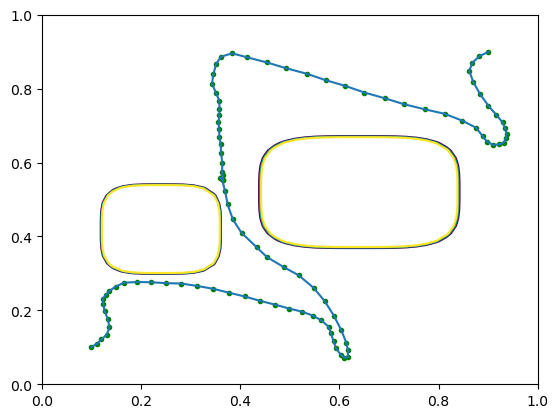

In [20]:
X, Y = np.meshgrid(*[np.linspace(0,1)]*2)
pnts = np.vstack([X.ravel(), Y.ravel()]).T

sol = solver.get_solution()

## <---- below draws the objects ---->
# for obs in traj_opt.obs:
#     _patch = obs.draw()
#     plt.gca().add_patch(_patch)
_mixed_vals = np.inf*np.ones_like(X)
for _obs in obs:
    _vals = vmap(_obs.distance)(pnts).reshape(X.shape)
    _mixed_vals = np.minimum(_vals, _mixed_vals)
    plt.contour(X, Y, _vals.reshape(X.shape), levels=[-0.01,0.,0.01])
plt.plot(sol['x'][:,0], sol['x'][:,1],'g.')
plt.plot(sol['x'][:,0], sol['x'][:,1])

In [21]:
sol['tf'], ineq_constr(sol, opt_args)[:2]

(Array(8.801584, dtype=float32, weak_type=True),
 Array([-0.02973067, -8.801584  ], dtype=float32))

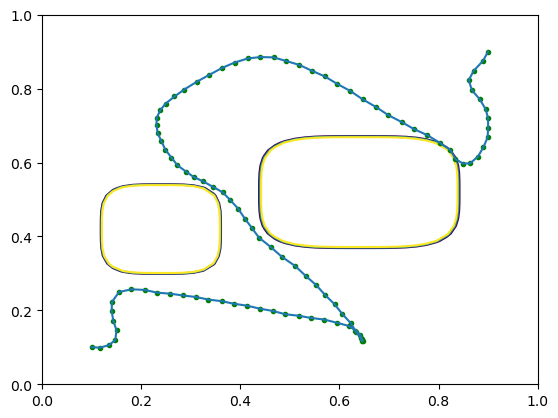

In [9]:
for kk in range(100):
    solver.solve(max_iter=100)

    X, Y = np.meshgrid(*[np.linspace(0,1)]*2)
    pnts = np.vstack([X.ravel(), Y.ravel()]).T

    sol = solver.get_solution()
    
    if kk % 1 == 0:
        clear_output(wait=True)
        ## <---- below draws the objects ---->
        # for obs in traj_opt.obs:
        #     _patch = obs.draw()
        #     plt.gca().add_patch(_patch)
        _mixed_vals = np.inf*np.ones_like(X)
        for _obs in obs:
            _vals = vmap(_obs.distance)(pnts).reshape(X.shape)
            _mixed_vals = np.minimum(_vals, _mixed_vals)
            plt.contour(X, Y, _vals.reshape(X.shape), levels=[-0.01,0.,0.01])
        plt.plot(sol['x'][:,0], sol['x'][:,1],'g.')
        plt.plot(sol['x'][:,0], sol['x'][:,1])
        # target_distr.plot()
        # circle1 = plt.Circle((2.5,1.0), 0.75, color='r')
        # circle2 = plt.Circle((4.5,1.0), 0.5, color='r')

        # plt.gca().add_patch(circle1)
        # plt.gca().add_patch(circle2)
        # plt.axis('square')

        # plt.xlim(0.,1.0) 
        # plt.ylim(0.,1.0)
        plt.show()

In [10]:
sol['tf'], ineq_constr(sol, opt_args)[:2]

(Array(2.589491, dtype=float32, weak_type=True),
 Array([-6.8694353e-06, -2.5894909e+00], dtype=float32))

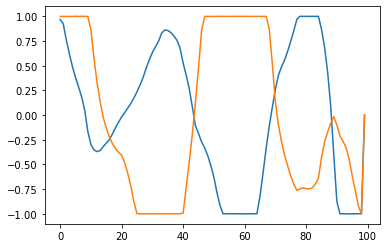

In [9]:
plt.plot(sol['u'])

In [10]:
sol['tf']

DeviceArray(4.3329153, dtype=float32, weak_type=True)

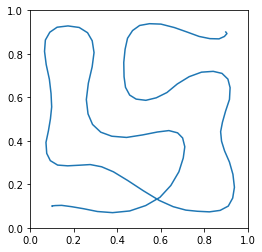

In [7]:
sol = solver.get_solution()
plt.plot(sol['x'][:,0], sol['x'][:,1])
plt.axis('square')

plt.xlim(0.,1.0) 
plt.ylim(0.,1.0)
plt.show()

In [8]:
sol['tf']

DeviceArray(4.3329153, dtype=float32, weak_type=True)

In [16]:
ineq_constr(sol, opt_args)[:2]

DeviceArray([ 8.4029138e-04, -1.0808266e+01], dtype=float32)

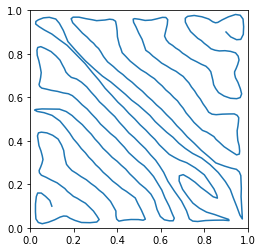

In [18]:
traj_opt = ErgodicTrajectoryOpt()
for kk in range(100):
    traj_opt.solver.solve(max_iter=100)

    X, Y = np.meshgrid(*[np.linspace(-2,2)]*2)
    pnts = np.vstack([X.ravel(), Y.ravel()]).T

    sol = traj_opt.solver.get_solution()
    
    if kk % 1 == 0:
        clear_output(wait=True)
        ## <---- below draws the objects ---->
        # for obs in traj_opt.obs:
        #     _patch = obs.draw()
        #     plt.gca().add_patch(_patch)
        # _mixed_vals = np.inf*np.ones_like(X)
        # for obs in traj_opt.obs:
        #     _vals = vmap(obs.distance)(pnts).reshape(X.shape)
        #     _mixed_vals = np.minimum(_vals, _mixed_vals)
        #     plt.contour(X, Y, _vals.reshape(X.shape), levels=[-0.01,0.,0.01])
        plt.plot(sol['x'][:,0], sol['x'][:,1])

        # circle1 = plt.Circle((2.5,1.0), 0.75, color='r')
        # circle2 = plt.Circle((4.5,1.0), 0.5, color='r')

        # plt.gca().add_patch(circle1)
        # plt.gca().add_patch(circle2)
        plt.axis('square')

        plt.xlim(0.,1.0) 
        plt.ylim(0.,1.0)
        plt.show()

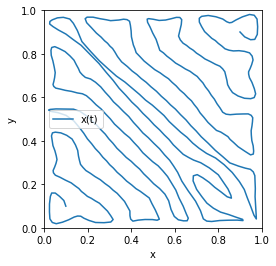

In [23]:
plt.plot(sol['x'][:,0], sol['x'][:,1], label='x(t)')

# circle1 = plt.Circle((2.5,1.0), 0.75, color='r')
# circle2 = plt.Circle((4.5,1.0), 0.5, color='r')

# plt.gca().add_patch(circle1)
# plt.gca().add_patch(circle2)
plt.axis('square')
plt.xlim(0.,1.0) 
plt.ylim(0.,1.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('erg_uniform_traj.png')
plt.show()

In [4]:
# sol = traj_opt.solver.get_solution()
X, Y = traj_opt.target_distr.domain
P = traj_opt.target_distr.evals[0].reshape(X.shape)
# clear_output(wait=T'rue)
# plt.contour(X, Y, P)
# plt.scatter(sol['x'][:,0], sol['x'][:,1])
# # plt.xlim(0,1)
# # plt.ylim(0,1)
# # plt.axis('square')
# plt.show()

In [5]:
for i in range(20):
    %time traj_opt.solver.solve(max_iter=100)

CPU times: user 905 ms, sys: 13 ms, total: 918 ms
Wall time: 876 ms
CPU times: user 66.5 ms, sys: 2.19 ms, total: 68.7 ms
Wall time: 46.4 ms
CPU times: user 53.1 ms, sys: 14.8 ms, total: 67.9 ms
Wall time: 45.8 ms
done in  47  iterations
CPU times: user 15.3 ms, sys: 18.4 ms, total: 33.7 ms
Wall time: 22.7 ms
CPU times: user 49.8 ms, sys: 19.9 ms, total: 69.7 ms
Wall time: 47 ms
CPU times: user 32.3 ms, sys: 37 ms, total: 69.3 ms
Wall time: 46.5 ms
done in  63  iterations
CPU times: user 46.1 ms, sys: 0 ns, total: 46.1 ms
Wall time: 31.1 ms
CPU times: user 53 ms, sys: 15.8 ms, total: 68.8 ms
Wall time: 46.5 ms
CPU times: user 63.2 ms, sys: 4.77 ms, total: 68 ms
Wall time: 45.8 ms
CPU times: user 55.9 ms, sys: 12.1 ms, total: 68 ms
Wall time: 45.7 ms
CPU times: user 58 ms, sys: 12.8 ms, total: 70.8 ms
Wall time: 47.7 ms
CPU times: user 57.8 ms, sys: 12.8 ms, total: 70.6 ms
Wall time: 47.6 ms
CPU times: user 54.3 ms, sys: 15.2 ms, total: 69.5 ms
Wall time: 46.8 ms
done in  71  iterations

In [6]:
X, Y = np.meshgrid(*[np.linspace(-2,2)]*2)
pnts = np.vstack([X.ravel(), Y.ravel()]).T
for _ in range(100):
    traj_opt.solver.solve(max_iter=50)
    sol = traj_opt.solver.get_solution()
    clear_output(wait=True)
    # plt.contour(X, Y, P)
    for obs in traj_opt.obs:
        _patch = obs.draw()
        plt.gca().add_patch(_patch)
    # _vals = 
    for obs in traj_opt.obs:
        _vals = vmap(obs.distance)(pnts)
        plt.contour(X, Y, _vals.reshape(X.shape), levels=[-0.01,0.,0.01])
    plt.plot(sol['x'][:,0], sol['x'][:,1], 'r')

    # circle1 = plt.Circle((2.5,1.0), 0.75, color='r')
    # circle2 = plt.Circle((4.5,1.0), 0.5, color='r')

    # plt.gca().add_patch(circle1)
    # plt.gca().add_patch(circle2)

    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.axis('equal')
    plt.show()

/tmp/ipykernel_12187/618753852.py:14: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, _vals.reshape(X.shape), levels=[-0.01,0.,0.01])


KeyboardInterrupt: 

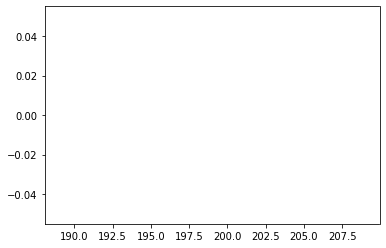

In [7]:
plt.plot(sol['x'][:,2:])

In [14]:
sol['x']

DeviceArray([[nan, nan, nan, nan],
             [nan, nan, nan, nan],
             [nan, nan, nan, nan],
             ...,
             [nan, nan, nan, nan],
             [nan, nan, nan, nan],
             [nan, nan, nan, nan]], dtype=float32)